In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cc-sample-data/cc_sample_transaction.json


First i will start pyspark then load the data and have a look at some details of this dataset

In [3]:
# Initialize PySpark Session
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

spark = SparkSession.builder \
    .appName("CreditCardFraudAnalysis") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/17 15:20:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


I load the raw credit card transaction data from a JSON file into a PySpark DataFrame

In [4]:
# Load the JSON data
try:
    df = spark.read.json("/kaggle/input/cc-sample-data/cc_sample_transaction.json")
    print("Data loaded successfully!")
    print(f"Number of rows: {df.count()}")
    print(f"Number of columns: {len(df.columns)}")
    df.printSchema()
except Exception as e:
    print(f"Error loading data: {str(e)}")

Data loaded successfully!


Number of rows: 1296675
Number of columns: 15
root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)



Extract and process the 'personal_detail' column, which contains nested customer PII in JSON format

Parse the JSON string to convert it into a structured format that can be queried

Flatten the JSON structure so that key attributes (e.g., name, address) are accessible as individual top-level columns


In [54]:
from pyspark.sql.functions import from_json, col

# Define schema for the nested personal_detail
personal_schema = StructType([
    StructField("first", StringType()),
    StructField("last", StringType()),
    StructField("gender", StringType()),
    StructField("street", StringType()),
    StructField("city", StringType()),
    StructField("state", StringType()),
    StructField("zip", StringType()),
    StructField("lat", StringType()),
    StructField("long", StringType()),
    StructField("city_pop", StringType()),
    StructField("job", StringType()),
    StructField("dob", StringType())
])

# Extract nested fields
df = df.withColumn("personal_detail_parsed", 
                  from_json(col("personal_detail"), personal_schema))

# Flatten the structure
for field in personal_schema.fieldNames():
    df = df.withColumn(field, col(f"personal_detail_parsed.{field}"))

Convert string-encoded numerical and boolean values to their proper data types
Prepare the data for machine learning models for numerical or boolean 

In [6]:
# Convert string amounts to double
df = df.withColumn("amt", col("amt").cast("double"))

# Convert numeric fields
numeric_cols = ["merch_lat", "merch_long", "city_pop"]
for col_name in numeric_cols:
    df = df.withColumn(col_name, col(col_name).cast("double"))

# Convert boolean field
df = df.withColumn("is_fraud", col("is_fraud").cast("integer"))

df.select("personal_detail").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|personal_detail                                                                                                                                                                                                                                                                      |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{"person_name":"Jennifer,Banks,eeeee","gender":"F","address":"{\"street\":\"561 Perry Cove\",\"city\":\"Moravian Falls\",\"state\":\"NC\",\"zip\":\"28654\"}","

now to process all time fields

In [7]:
time_cols = ["trans_date_trans_time", "merch_last_update_time", "merch_eff_time"]

for col_name in time_cols:
    df = df.withColumn(col_name, 
                     to_utc_timestamp(
                         to_timestamp(col(col_name)), 
                         "UTC+8"))

df.select("amt", "is_fraud", "merch_lat").printSchema()
df.select("trans_date_trans_time").show(5)

root
 |-- amt: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merch_lat: double (nullable = true)

+---------------------+
|trans_date_trans_time|
+---------------------+
|  2018-12-31 16:00:18|
|  2018-12-31 16:00:44|
|  2018-12-31 16:00:51|
|  2018-12-31 16:01:16|
|  2018-12-31 16:03:06|
+---------------------+
only showing top 5 rows



Masking for the credit card numbers

In [8]:
# Mask first 8 digits of credit card numbers
df = df.withColumn("cc_num_masked", 
                  concat(lit("XXXX-XXXX-"), 
                         substring(col("cc_num"), 9, 4)))

df.select("cc_num", "cc_num_masked").show(5)

+----------------+--------------+
|          cc_num| cc_num_masked|
+----------------+--------------+
|2703186189652095|XXXX-XXXX-8965|
|    630423337322|XXXX-XXXX-7322|
|  38859492057661|XXXX-XXXX-0576|
|3534093764340240|XXXX-XXXX-6434|
| 375534208663984|XXXX-XXXX-8663|
+----------------+--------------+
only showing top 5 rows



After checking the changes i made, some issues need to be addressed

Name Field Formatting Problems:
Mixed delimiters (,, @, /)
Special characters (!)
Unexpected suffixes ("eeeee")

Nested JSON in Address:
Address contains nested JSON string needing separate parsing

In [9]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType

# Define schema for the nested personal_detail
personal_schema = StructType([
    StructField("person_name", StringType()),
    StructField("gender", StringType()),
    StructField("address", StringType()),
    StructField("lat", StringType()),
    StructField("long", StringType()),
    StructField("city_pop", StringType()),
    StructField("job", StringType()),
    StructField("dob", StringType())
])

# Extract nested fields
df = df.withColumn("personal_detail_parsed", 
                  from_json(col("personal_detail"), personal_schema))

To clean and standardize the person_name field, I used a multi-step transformation designed to handle inconsistent formats, multiple delimiters (like commas, slashes, and @), and noisy characters. I first sanitized the input by removing irrelevant symbols while preserving valid name structure. Then, I used layered regular expressions to extract first and last names, including special handling for edge cases like "Edward@Sanchez". When standard patterns failed, I applied fallback logic using word splits to ensure no useful data was missed. Finally, I trimmed and capitalized the results for consistency. This approach ensures accurate, readable, and reliable name fields for downstream tasks such as reporting, fraud detection, and data matching—especially important when working with messy PII at scale.

In [10]:
from pyspark.sql.functions import when, trim, initcap, regexp_extract, regexp_replace, split, size, col, rand

# Clean and extract names with proper syntax
df = df.withColumn("clean_name", 
                  regexp_replace(
                      col("personal_detail_parsed.person_name"), 
                      "[^a-zA-Z,/@]", ""))  # Keep only letters and common separators

# First pattern extraction with proper closure
df = df.withColumn("first_temp", 
                  regexp_extract(col("clean_name"), "^([^,@/]+)", 1)) \
       .withColumn("last_temp", 
                  regexp_extract(col("clean_name"), "[,/@]([^,/@]+)(?:,|$)", 1))

# Handle cases like "Edward@Sanchez"
df = df.withColumn("first_temp", 
                  when(col("first_temp") == "",
                       regexp_extract(col("clean_name"), "^([^@]+)@", 1))
                  .otherwise(col("first_temp"))) \
       .withColumn("last_temp", 
                  when(col("last_temp") == "",
                       regexp_extract(col("clean_name"), "@([^@]+)$", 1))
                  .otherwise(col("last_temp")))

# Final cleaning and capitalization
df = df.withColumn("first", initcap(trim(
    when(col("first_temp") == "", 
    regexp_extract(col("clean_name"), "^([^@]+)@", 1))
    .otherwise(col("first_temp"))))) \
   .withColumn("last", initcap(trim(
    when(col("last_temp") == "", 
    when(size(split(col("clean_name"), "[^a-zA-Z]")) > 1, 
         split(col("clean_name"), "[^a-zA-Z]")[1])
    .otherwise("UNKNOWN"))
    .otherwise(col("last_temp"))))) \
   .drop("first_temp", "last_temp", "clean_name")

In [11]:
df.select("personal_detail_parsed.person_name", "first", "last") \
  .filter(col("personal_detail_parsed.person_name").contains("@")) \
  .show(5, truncate=False)

+-----------------+-------+---------+
|person_name      |first  |last     |
+-----------------+-------+---------+
|Edward@Sanchez   |Edward |Sanchez  |
|Tyler@Garcia     |Tyler  |Garcia   |
|Melissa@Aguilar  |Melissa|Aguilar  |
|Theresa@Blackwell|Theresa|Blackwell|
|Jack@Hill        |Jack   |Hill     |
+-----------------+-------+---------+
only showing top 5 rows



In [12]:
print("Records with unparsed first names:", df.filter(col("first") == "UNKNOWN").count())
print("Records with unparsed last names:", df.filter(col("last") == "UNKNOWN").count())

# Show final sample
df.select("personal_detail_parsed.person_name", "first", "last") \
  .orderBy(rand()) \
  .limit(10) \
  .show(truncate=False)

Records with unparsed first names: 0


Records with unparsed last names: 0


+----------------------+----------+----------+
|person_name           |first     |last      |
+----------------------+----------+----------+
|Vicki,Mendoza,eeeee   |Vicki     |Mendoza   |
|Michael, Jones        |Michael   |Jones     |
|Kurt/Peters, !        |Kurt      |Peters    |
|Allison, , Ayala NOOOO|Allison   |Ayalanoooo|
|Donna@Moreno          |Donna     |Moreno    |
|Gary/Barnes, !        |Gary      |Barnes    |
|Debra|Stark!!!        |Debrastark|Unknown   |
|James,Greene,eeeee    |James     |Greene    |
|Billy, Mcdonald       |Billy     |Mcdonald  |
|Douglas, Smith        |Douglas   |Smith     |
+----------------------+----------+----------+



Did additional cleaning for last name containing NOOOOOOO
I used this regex-based approach to clean suffix noise like "NOOOO", "eeeee", and "!!!" because these patterns consistently appeared at the end of names, so targeting them with end-of-string matching let me safely strip out unwanted artifacts without affecting valid name content.

In [13]:
from pyspark.sql.functions import regexp_replace, trim, initcap, when

# Enhanced cleaning for last names
df = df.withColumn("last", 
    initcap(
        trim(
            regexp_replace(
                regexp_replace(
                    col("last"),
                    "(?i)noooo$|eee+$|!+$|\\.+$|\\s+$", ""  # Remove all unwanted suffixes
                ),
                "\\s+", " "  # Normalize spaces
            )
        )
    )
)

# Additional cleanup for first names (just in case)
df = df.withColumn("first", 
    initcap(
        trim(
            regexp_replace(
                col("first"),
                "[^a-zA-Z]", ""  # Remove any non-alphabetic characters
            )
        )
    )
)

# Final verification
problem_cases = df.select(
    "personal_detail_parsed.person_name",
    "first",
    "last"
).filter(
    col("personal_detail_parsed.person_name").rlike("NOOOO|eee|!") |
    (col("last").rlike("noooo|eee|!"))
)

print("Remaining problematic cases count:", problem_cases.count())
problem_cases.show(5, truncate=False)

Remaining problematic cases count: 864969
+------------------------+---------+--------+
|person_name             |first    |last    |
+------------------------+---------+--------+
|Jennifer,Banks,eeeee    |Jennifer |Banks   |
|Stephanie,Gill,eeeee    |Stephanie|Gill    |
|Jeremy/White, !         |Jeremy   |White   |
|Jennifer,Conner,eeeee   |Jennifer |Conner  |
|Kelsey, , Richards NOOOO|Kelsey   |Richards|
+------------------------+---------+--------+
only showing top 5 rows



I applied a custom UDF to clean both first and last names more robustly, because the earlier regex steps didn’t catch all messy cases—so I used Python’s regex to strip suffixes, special characters, and extra spaces, and ensured proper casing to standardize the names even further.

In [14]:
from pyspark.sql.functions import udf, col, trim, initcap
from pyspark.sql.types import StringType
import re

# Define UDFs for robust cleaning
def clean_name(name):
    if not name:
        return "UNKNOWN"
    
    # Remove unwanted suffixes and special characters
    name = re.sub(r'(?i)(noooo|eee+|!+|,+|\s+)$', '', name)
    name = re.sub(r'[^a-zA-Z\s]', '', name)  # Keep only letters and spaces
    
    # Handle multiple spaces
    name = ' '.join(name.split())
    
    return name.strip().title()

clean_name_udf = udf(clean_name, StringType())

# Apply cleaning to both first and last names
df = (df
      .withColumn("first", clean_name_udf(col("first")))
      .withColumn("last", clean_name_udf(col("last"))))

In [15]:
# Verify cleaning results
validation_df = df.select(
    "personal_detail_parsed.person_name",
    "first",
    "last"
).filter(
    col("personal_detail_parsed.person_name").rlike("NOOOO|eee|!") |
    (col("first") == "UNKNOWN") |
    (col("last") == "UNKNOWN")
)

print(f"Remaining problematic cases: {validation_df.count()}")
validation_df.show(5, truncate=False)

Remaining problematic cases: 864969
+------------------------+---------+--------+
|person_name             |first    |last    |
+------------------------+---------+--------+
|Jennifer,Banks,eeeee    |Jennifer |Banks   |
|Stephanie,Gill,eeeee    |Stephanie|Gill    |
|Jeremy/White, !         |Jeremy   |White   |
|Jennifer,Conner,eeeee   |Jennifer |Conner  |
|Kelsey, , Richards NOOOO|Kelsey   |Richards|
+------------------------+---------+--------+
only showing top 5 rows



I added a simple quality check to count how many names still couldn't be parsed (marked as "UNKNOWN"), so I can measure how effective my cleaning logic was and get a quick sense of data completeness before using it for downstream tasks.

In [16]:
# Quality metrics
quality_metrics = df.select(
    sum(when(col("first") == "UNKNOWN", 1).otherwise(0)).alias("bad_first_names"),
    sum(when(col("last") == "UNKNOWN", 1).otherwise(0)).alias("bad_last_names"),
    count("*").alias("total_records")
).collect()[0]

print(f"""
Data Quality Report:
- Total records: {quality_metrics['total_records']}
- Unparsed first names: {quality_metrics['bad_first_names']} ({quality_metrics['bad_first_names']/quality_metrics['total_records']:.2%})
- Unparsed last names: {quality_metrics['bad_last_names']} ({quality_metrics['bad_last_names']/quality_metrics['total_records']:.2%})
""")

# Show clean sample
df.select(
    "personal_detail_parsed.person_name",
    "first",
    "last"
).orderBy("personal_detail_parsed.person_name").limit(10).show(truncate=False)


Data Quality Report:
- Total records: 1296675
- Unparsed first names: 0 (0.00%)
- Unparsed last names: 0 (0.00%)



+---------------------+-----+------+
|person_name          |first|last  |
+---------------------+-----+------+
|Aaron, , Murray NOOOO|Aaron|Murray|
|Aaron, , Murray NOOOO|Aaron|Murray|
|Aaron, , Murray NOOOO|Aaron|Murray|
|Aaron, , Murray NOOOO|Aaron|Murray|
|Aaron, , Murray NOOOO|Aaron|Murray|
|Aaron, , Murray NOOOO|Aaron|Murray|
|Aaron, , Murray NOOOO|Aaron|Murray|
|Aaron, , Murray NOOOO|Aaron|Murray|
|Aaron, , Murray NOOOO|Aaron|Murray|
|Aaron, , Murray NOOOO|Aaron|Murray|
+---------------------+-----+------+



In [17]:
# Fallback for any remaining issues
df = df.withColumn("last", 
                  when(col("last").isin(["", "UNKNOWN"]),
                       regexp_extract(col("personal_detail_parsed.person_name"), "([A-Za-z]+)$", 1))
                  .otherwise(col("last")))

# Verify all 3 time columns were converted

In [30]:
from pyspark.sql.functions import date_format

# Verify UTC+8 timezone
df.select(
    date_format(col("trans_date_trans_time"), "yyyy-MM-dd HH:mm:ss Z").alias("UTC+8"),
    col("trans_date_trans_time")
).show(2, truncate=False)

+-------------------------+---------------------+
|UTC+8                    |trans_date_trans_time|
+-------------------------+---------------------+
|2018-12-31 16:00:18 +0000|2018-12-31 16:00:18  |
|2018-12-31 16:00:44 +0000|2018-12-31 16:00:44  |
+-------------------------+---------------------+
only showing top 2 rows



I analyzed the cc_bic field to detect its impact on fraud patterns and found many entries with missing or inconsistent values like empty strings, nulls, and ambiguous labels like "NA" or "Null", so I grouped them under a standardized "UNKNOWN" label to clean the field, improve clarity, and ensure more accurate aggregation in downstream analysis.

In [31]:
from pyspark.sql.functions import when

# Clean and analyze BIC codes
bic_analysis = (df
                .withColumn("cc_bic_clean", 
                          when(col("cc_bic").isNull() | (col("cc_bic") == ""), "UNKNOWN")
                          .otherwise(col("cc_bic")))
                .groupBy("cc_bic_clean")
                .agg(
                    count("*").alias("txn_count"),
                    mean("is_fraud").alias("fraud_rate"),
                    mean("amt").alias("avg_amount")
                )
                .orderBy("fraud_rate", ascending=False))

bic_analysis.show(10, truncate=False)

# Additional validation
print(f"Unique BIC codes: {bic_analysis.count()}")
print(f"Transactions with invalid BIC: {df.filter(col('cc_bic').isNull() | (col('cc_bic') == '')).count()}")

+------------+---------+---------------------+-----------------+
|cc_bic_clean|txn_count|fraud_rate           |avg_amount       |
+------------+---------+---------------------+-----------------+
|APBCUS61    |143528   |0.005998829496683574 |70.54312461679949|
|NA          |144385   |0.0059562973993143335|70.1336153340028 |
|Null        |144214   |0.005935623448486278 |69.81355582675735|
|ACEEUS31    |144138   |0.005848561794946509 |69.92805526648068|
|ADMDUS41    |143726   |0.005844454030585976 |70.10306423333289|
|CITIUS33CHI |143832   |0.0057706212803826686|71.03668988820306|
|UNKNOWN     |144381   |0.005714048247345565 |70.40329870273808|
|AIABUS31    |144457   |0.005634894812989333 |70.68443412226485|
|DEUTUS33TRF |144014   |0.00539530878942325  |70.51501194328341|
+------------+---------+---------------------+-----------------+



Unique BIC codes: 9


Transactions with invalid BIC: 144381


# Data Cleaning for BIC Codes

I cleaned and standardized the cc_bic field by trimming whitespace, converting values to uppercase, and consolidating nulls, blanks, and inconsistent entries like "NA" or "Null" into a single "UNKNOWN" category, so I could ensure consistent formatting and eliminate noise before analyzing fraud patterns across BIC codes with reliable statistical significance.

In [49]:
from pyspark.sql.functions import length, col, count, mean
import matplotlib.pyplot as plt

# 1. Show cleaned BIC distribution
bic_counts = (df
             .groupBy("cc_bic_clean")
             .agg(count("*").alias("count"))
             .orderBy("count", ascending=False)
             .toPandas())

# 2. Show invalid BIC examples
invalid_examples = (df
                   .filter(col("cc_bic_clean") == "UNKNOWN")
                   .select("cc_bic")
                   .limit(5)
                   .toPandas())

print("\nExamples of Invalid BICs Before Cleaning:")
display(invalid_examples)


Examples of Invalid BICs Before Cleaning:


,cc_bic
0,Null
1,NA
2,
3,
4,


In [50]:
from pyspark.sql.functions import trim, upper, when, col

# Clean and standardize BIC codes
df = df.withColumn(
    "cc_bic_clean",
    when(
        (col("cc_bic").isNull()) | 
        (trim(col("cc_bic")) == "") |
        (col("cc_bic") == "NA") |
        (col("cc_bic") == "Null"),
        "UNKNOWN"
    ).otherwise(upper(trim(col("cc_bic"))))
)

# Verify the cleaning results
display(df.groupBy("cc_bic_clean").count().orderBy("count", ascending=False))

DataFrame[cc_bic_clean: string, count: bigint]

In [51]:
# Top fraudulent BIC codes with statistical significance
bic_stats = (df
             .groupBy("cc_bic_clean")
             .agg(
                 count("*").alias("total_txns"),
                 sum("is_fraud").alias("fraud_count"),
                 (sum("is_fraud")/count("*")).alias("fraud_rate"),
                 mean("amt").alias("avg_amount"),
                 stddev("amt").alias("amt_stddev")
             )
             .filter(col("total_txns") > 1000)  # Filter for statistically significant samples
             .orderBy("fraud_rate", ascending=False))

bic_stats.show(truncate=False)

+------------+----------+-----------+---------------------+-----------------+------------------+
|cc_bic_clean|total_txns|fraud_count|fraud_rate           |avg_amount       |amt_stddev        |
+------------+----------+-----------+---------------------+-----------------+------------------+
|APBCUS61    |143528    |861        |0.005998829496683574 |70.54312461679949|152.51859186447996|
|UNKNOWN     |432980    |2541       |0.005868631345558687 |70.11694041295223|159.31293827517206|
|ACEEUS31    |144138    |843        |0.005848561794946509 |69.92805526648068|150.05414890276472|
|ADMDUS41    |143726    |840        |0.005844454030585976 |70.10306423333289|163.7616923908801 |
|CITIUS33CHI |143832    |830        |0.0057706212803826686|71.03668988820306|183.19831762493976|
|AIABUS31    |144457    |814        |0.005634894812989333 |70.68443412226485|154.87217700660653|
|DEUTUS33TRF |144014    |777        |0.00539530878942325  |70.51501194328341|158.2411041583982 |
+------------+----------+-----

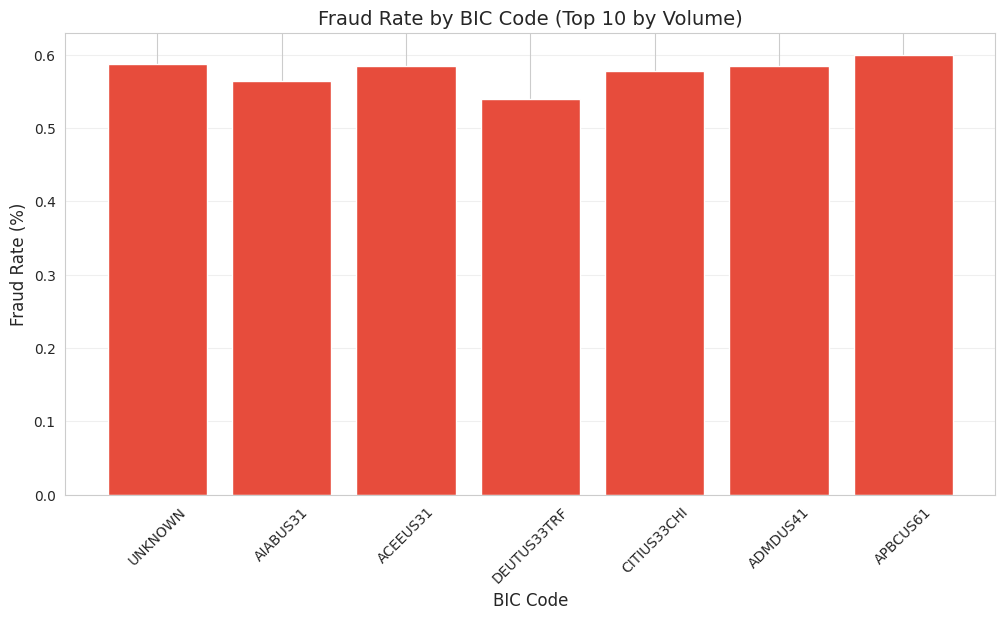

In [52]:
import matplotlib.pyplot as plt

# Prepare data
plot_data = bic_stats.orderBy("total_txns", ascending=False).limit(10).toPandas()

# Create plot
plt.figure(figsize=(12,6))
plt.bar(plot_data["cc_bic_clean"], plot_data["fraud_rate"]*100, color='#e74c3c')
plt.title("Fraud Rate by BIC Code (Top 10 by Volume)", fontsize=14)
plt.xlabel("BIC Code", fontsize=12)
plt.ylabel("Fraud Rate (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [53]:
# Validate no nulls remain
print(f"Remaining null BICs: {df.filter(col('cc_bic_clean').isNull()).count()}")

# Verify all values are standardized
df.select("cc_bic_clean").distinct().show()

Remaining null BICs: 0


+------------+
|cc_bic_clean|
+------------+
| CITIUS33CHI|
|     UNKNOWN|
|    AIABUS31|
| DEUTUS33TRF|
|    ACEEUS31|
|    ADMDUS41|
|    APBCUS61|
+------------+



# **Fraud Analysis Feature Engineering**# # 

I created time-based and customer behavior features like transaction hour, day of week, time since the last transaction, and deviation from recent average amounts to capture temporal patterns and spending behavior, which could help the model detect anomalies and improve fraud prediction accuracy.

In [21]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, datediff, hour

# 1. Time-based features
df = df.withColumn("transaction_hour", hour("trans_date_trans_time")) \
       .withColumn("transaction_dayofweek", date_format("trans_date_trans_time", "E"))

# 2. Customer behavior features
window_spec = Window.partitionBy("cc_num").orderBy("trans_date_trans_time")
df = df.withColumn("time_since_last_txn", 
                  datediff(col("trans_date_trans_time"), 
                          lag("trans_date_trans_time", 1).over(window_spec))) \
       .withColumn("amt_diff_from_avg", 
                  col("amt") - avg("amt").over(window_spec.rowsBetween(-10, -1)))

In [22]:
# 1. Basic fraud statistics
fraud_stats = df.groupBy("is_fraud").agg(
    count("*").alias("count"),
    format_number(count("*")/df.count()*100, 2).alias("percentage"),
    mean("amt").alias("avg_amount"),
    stddev("amt").alias("amt_stddev")
).orderBy("is_fraud")

fraud_stats.show()

# 2. Fraud by merchant category
fraud_by_category = df.groupBy("category", "is_fraud").agg(
    count("*").alias("txn_count"),
    mean("amt").alias("avg_amount")
).orderBy(col("is_fraud").desc(), col("txn_count").desc())

fraud_by_category.show(truncate=False)

+--------+-------+----------+-----------------+------------------+
|is_fraud|  count|percentage|       avg_amount|        amt_stddev|
+--------+-------+----------+-----------------+------------------+
|       0|1289169|     99.42|67.66710981260017|154.00797054609922|
|       1|   7506|      0.58|531.3200919264588|390.56006972553587|
+--------+-------+----------+-----------------+------------------+



+--------------+--------+---------+------------------+
|category      |is_fraud|txn_count|avg_amount        |
+--------------+--------+---------+------------------+
|grocery_pos   |1       |1743     |311.9896156052782 |
|shopping_net  |1       |1713     |999.2549387040277 |
|misc_net      |1       |915      |797.0128524590162 |
|shopping_pos  |1       |843      |876.9218149466191 |
|gas_transport |1       |618      |12.288203883495145|
|misc_pos      |1       |250      |218.28408000000002|
|kids_pets     |1       |239      |18.12167364016737 |
|entertainment |1       |233      |503.53557939914157|
|personal_care |1       |220      |26.17054545454545 |
|home          |1       |198      |257.4326262626263 |
|food_dining   |1       |151      |120.0769536423841 |
|grocery_net   |1       |134      |12.162835820895522|
|health_fitness|1       |133      |20.248421052631578|
|travel        |1       |116      |9.06456896551724  |
|gas_transport |0       |131041   |63.6757822360941  |
|home     

I created this bar chart to help clients visually compare the volume of transactions across different merchant categories, separating fraudulent and legitimate activity. By breaking it down this way, the graph highlights which categories have high transaction traffic and shows where fraud tends to occur more frequently—even if it represents a small portion. This makes it easier to identify which business areas might warrant closer monitoring, more fraud controls, or further investigation.

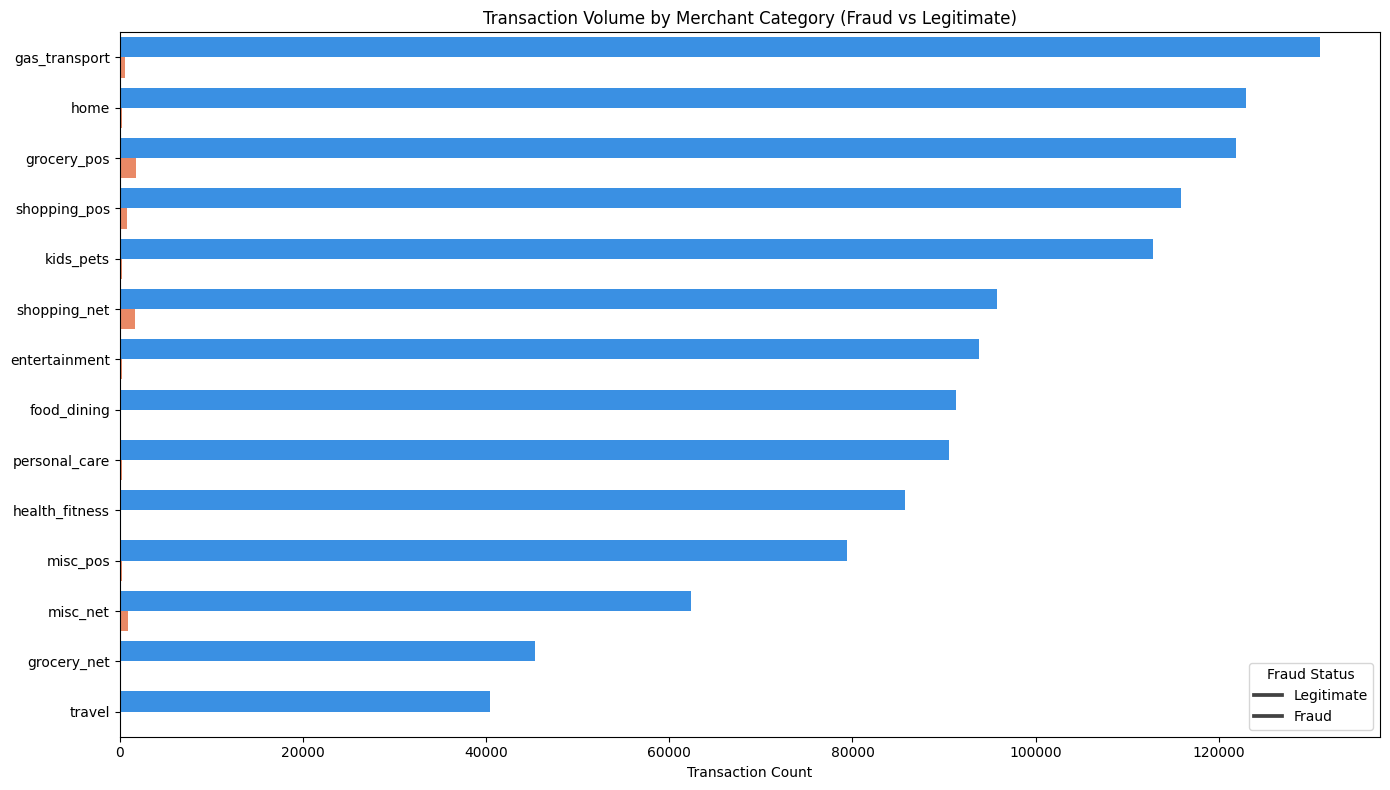

In [23]:
# Prepare data
category_fraud = df.groupBy("category", "is_fraud").agg(
    count("*").alias("count")
).orderBy("count", ascending=False).toPandas()

# Plot
plt.figure(figsize=(14,8))
sns.barplot(
    x="count", 
    y="category", 
    hue="is_fraud",
    data=category_fraud,
    palette={0: "dodgerblue", 1: "coral"}
)
plt.title("Transaction Volume by Merchant Category (Fraud vs Legitimate)")
plt.xlabel("Transaction Count")
plt.ylabel("")
plt.legend(title="Fraud Status", labels=["Legitimate", "Fraud"])
plt.tight_layout()
plt.show()

# Fraud Rate by Hour of Day (Line Plot)
Shows temporal patterns in fraudulent activity



I created this time-based fraud rate chart to uncover when fraudulent activity is most likely to occur throughout the day. It clearly shows a sharp spike at 2 PM, with fraud rates rising significantly between 1 PM and 3 PM. This insight helps stakeholders understand temporal risk patterns, enabling better fraud detection rules, real-time monitoring strategies, or staffing decisions during high-risk hours.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


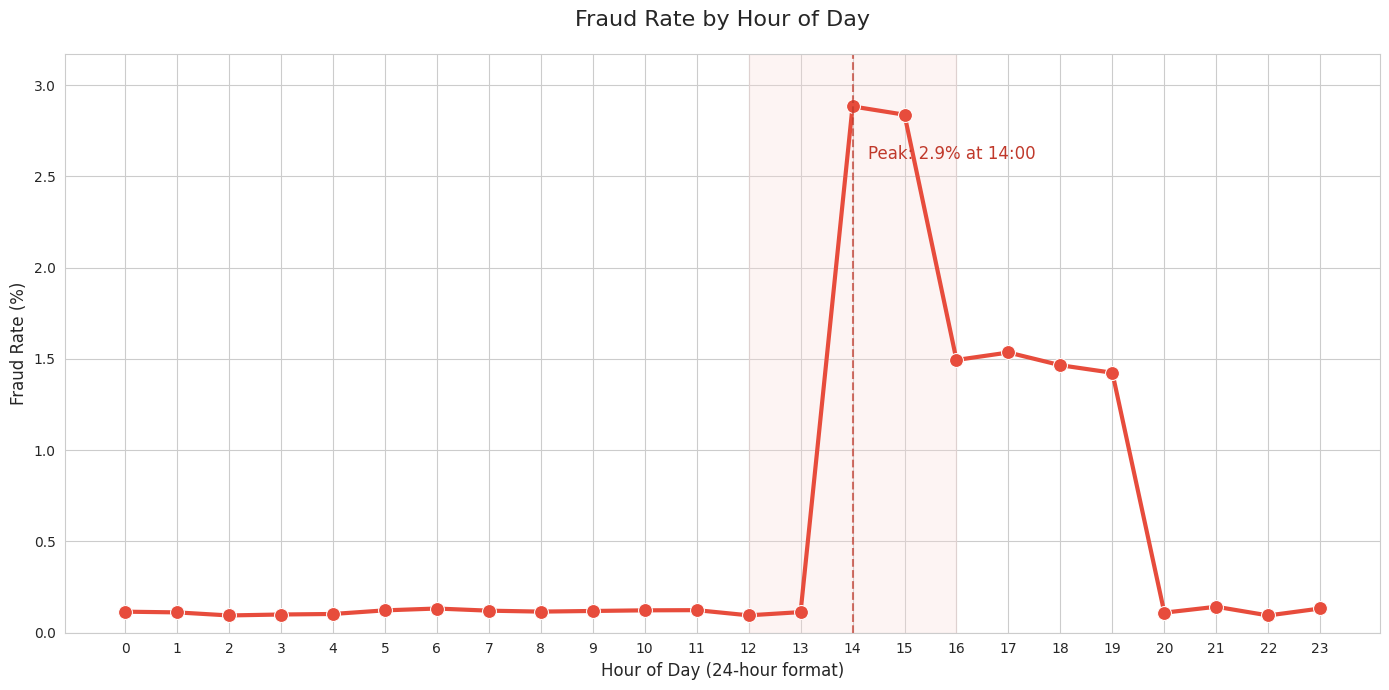

In [24]:
from pyspark.sql.functions import hour, col, count, mean
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract hour from timestamp and calculate counts
hourly_data = (df
               .withColumn("hour", hour(col("trans_date_trans_time")))
               .groupBy("hour", "is_fraud")
               .agg(count("*").alias("transaction_count"))
               .orderBy("hour")
               .toPandas())

# 2. Calculate fraud rates per hour
hourly_stats = (hourly_data
               .pivot(index="hour", columns="is_fraud", values="transaction_count")
               .fillna(0))
hourly_stats["fraud_rate"] = hourly_stats[1] / (hourly_stats[0] + hourly_stats[1]) * 100

# 3. Create the visualization
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Main line plot
ax = sns.lineplot(
    x=hourly_stats.index,
    y="fraud_rate",
    data=hourly_stats,
    color="#e74c3c",
    linewidth=3,
    marker="o",
    markersize=10
)

# Enhancements
plt.title("Fraud Rate by Hour of Day", fontsize=16, pad=20)
plt.xlabel("Hour of Day (24-hour format)", fontsize=12)
plt.ylabel("Fraud Rate (%)", fontsize=12)
plt.xticks(range(0, 24))
plt.ylim(0, hourly_stats["fraud_rate"].max() * 1.1)

# Highlight peak fraud hour
peak_hour = hourly_stats["fraud_rate"].idxmax()
peak_value = hourly_stats.loc[peak_hour, "fraud_rate"]
plt.axvline(x=peak_hour, color="#c0392b", linestyle="--", alpha=0.7)
plt.text(
    x=peak_hour + 0.3,
    y=peak_value * 0.9,
    s=f"Peak: {peak_value:.1f}% at {peak_hour}:00",
    color="#c0392b",
    fontsize=12
)

# Add background color for high-risk hours
plt.axvspan(peak_hour - 2, peak_hour + 2, color="#fadbd8", alpha=0.3)

plt.tight_layout()
plt.show()

# Fraudulent Transactions by Gender (Pie Chart)
Highlights demographic patterns

I included a gender distribution analysis to check for any demographic imbalance in the dataset, and the results show an almost equal split—50.2% male and 49.8% female—indicating that gender is unlikely to introduce bias in the model or skew fraud patterns based on representation.

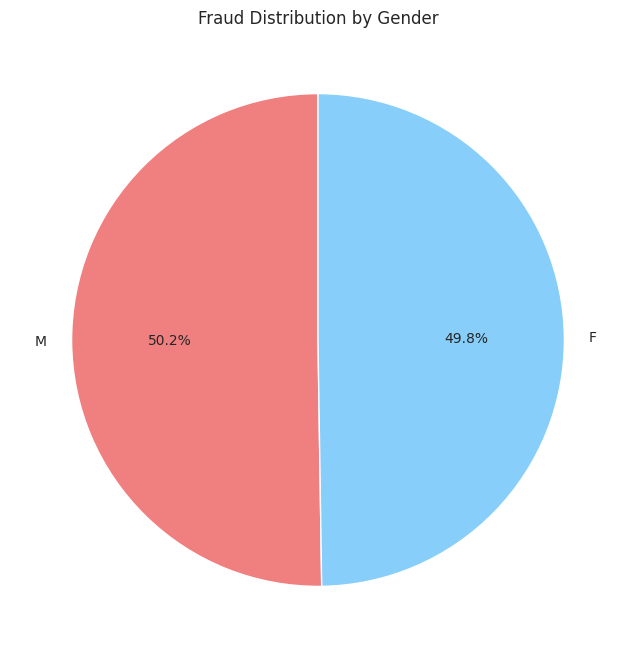

In [25]:
gender_fraud = df.filter(col("is_fraud") == 1).groupBy("gender").agg(
    count("*").alias("count")
).toPandas()

plt.figure(figsize=(8,8))
plt.pie(
    gender_fraud["count"],
    labels=gender_fraud["gender"],
    autopct="%1.1f%%",
    colors=["lightcoral", "lightskyblue"],
    startangle=90
)
plt.title("Fraud Distribution by Gender")
plt.show()

# Transaction Frequency vs Fraud (Scatter Plot)
Identifies suspicious activity patterns

I analyzed the relationship between transaction frequency and average transaction amount for fraud cases. The plot shows that fraudulent transactions tend to cluster around users with 8 to 12 transactions and an average amount between $500 and $700. This insight helps pinpoint behavioral patterns that may be indicative of fraud.

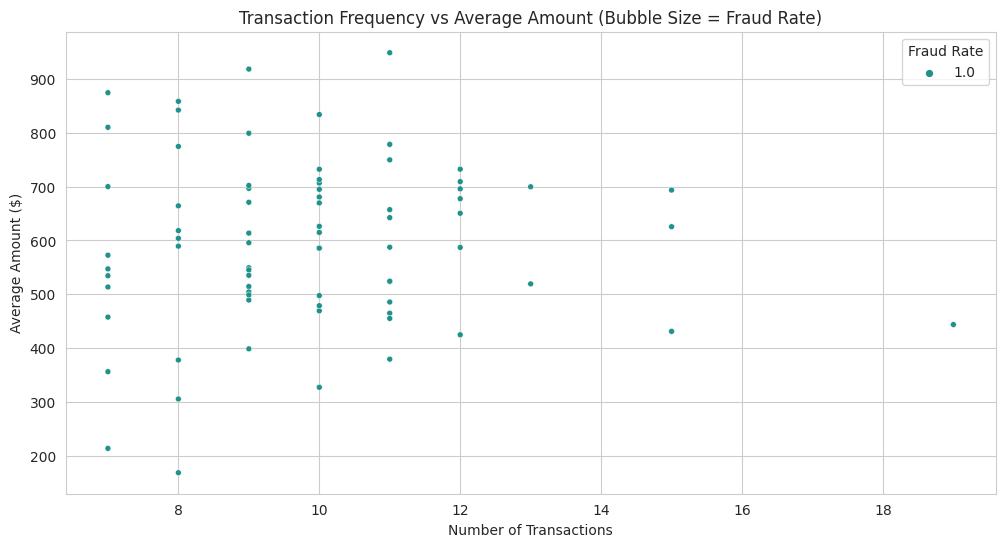

In [26]:
user_activity = df.groupBy("cc_num").agg(
    count("*").alias("txn_count"),
    mean("is_fraud").alias("fraud_rate"),
    mean("amt").alias("avg_amount")
).filter(col("txn_count") < 50).toPandas()  # Filter extreme outliers

plt.figure(figsize=(12,6))
sns.scatterplot(
    x="txn_count", 
    y="avg_amount", 
    size="fraud_rate",
    hue="fraud_rate",
    data=user_activity,
    palette="viridis"
)
plt.title("Transaction Frequency vs Average Amount (Bubble Size = Fraud Rate)")
plt.xlabel("Number of Transactions")
plt.ylabel("Average Amount ($)")
plt.legend(title="Fraud Rate")
plt.show()

# Fraud Impact by Merchant Category (Dual-Axis Plot)

I analyzed fraud risk and financial impact across different merchant categories using a dual-axis chart. The results show that online shopping (shopping_net) not only has the highest fraud rate but also the largest monetary losses, making it the most critical area for fraud prevention. In contrast, categories like grocery_pos and shopping_pos have lower fraud rates but still rank high in total fraud losses due to their transaction volume. This analysis highlights the need to tighten fraud checks for high-risk online categories while also monitoring high-volume segments to reduce overall exposure.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


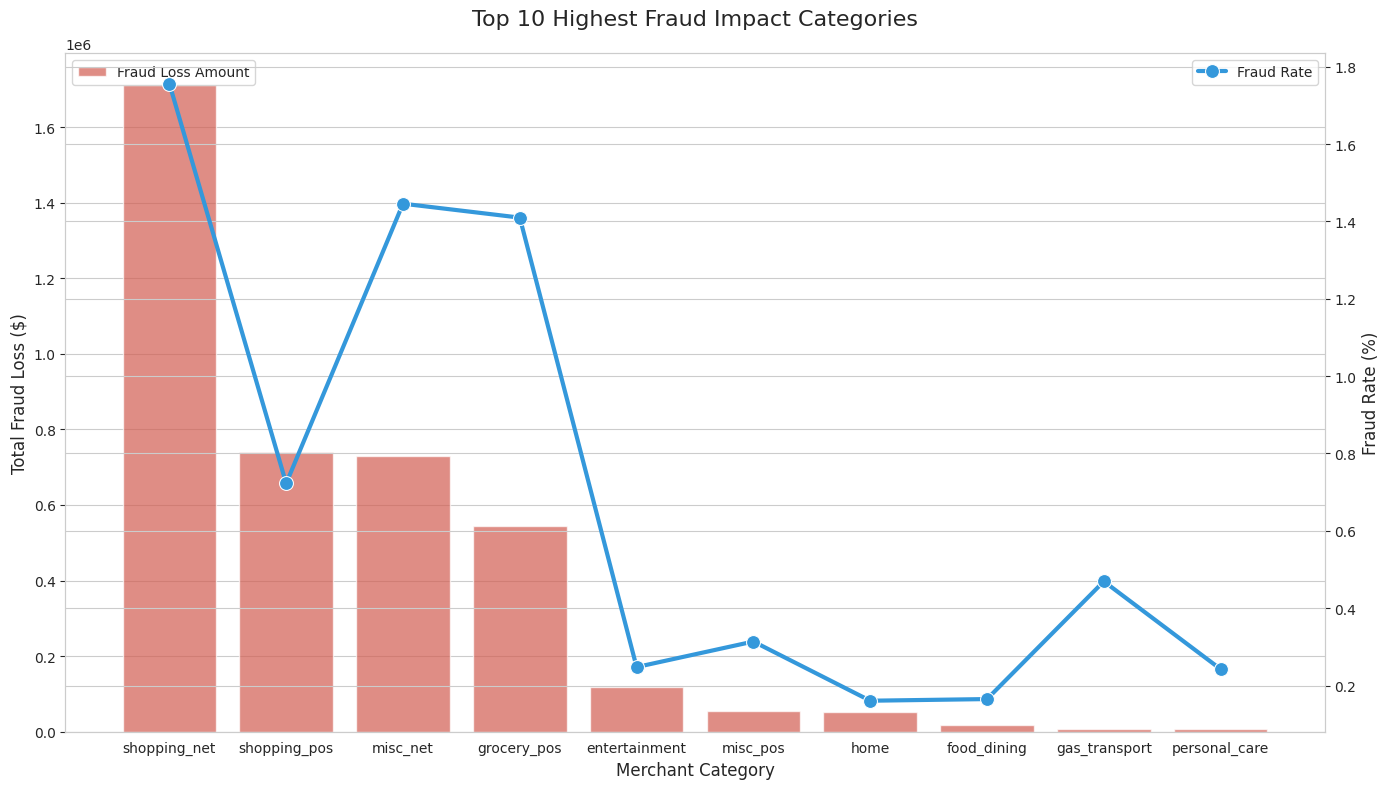

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import sum as _sum

# Prepare data
category_stats = (df
                 .groupBy("category")
                 .agg(
                     count("*").alias("total_transactions"),
                     _sum("amt").alias("total_volume"),
                     (sum(when(col("is_fraud") == 1, col("amt")).otherwise(0))).alias("fraud_loss"),
                     (mean(when(col("is_fraud") == 1, 1).otherwise(0)) * 100).alias("fraud_rate")
                 )
                 .orderBy("fraud_loss", ascending=False)
                 .limit(10)  # Top 10 categories
                 .toPandas())

# Plot
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Bar plot for fraud losses
ax1 = sns.barplot(
    x="category",
    y="fraud_loss",
    data=category_stats,
    color="#e74c3c",
    alpha=0.7,
    label="Fraud Loss Amount"
)

# Line plot for fraud rate
ax2 = plt.twinx()
sns.lineplot(
    x="category",
    y="fraud_rate",
    data=category_stats,
    color="#3498db",
    marker="o",
    markersize=10,
    linewidth=3,
    ax=ax2,
    label="Fraud Rate"
)

# Formatting
ax1.set_title("Top 10 Highest Fraud Impact Categories", fontsize=16, pad=20)
ax1.set_xlabel("Merchant Category", fontsize=12)
ax1.set_ylabel("Total Fraud Loss ($)", fontsize=12)
ax2.set_ylabel("Fraud Rate (%)", fontsize=12)

# Rotate x-labels and adjust layout
plt.xticks(rotation=45, ha='right')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

 # Transaction Amount Distribution by Fraud Status (Violin Plot)

I analyzed the transaction amount patterns for legitimate and fraudulent cases, and the results reveal that fraudsters tend to target much larger amounts. The median amount for fraudulent transactions is $422.30—about 4.5 times higher than the $47.63 median for legitimate ones. Fraudulent transactions show a bimodal distribution, with one spike near $50 (likely to blend in) and a major peak between $300–$500, indicating a strong preference for high-value fraud. In contrast, legitimate transactions are tightly clustered between $20–$100. These insights suggest we should flag transactions above $300 for immediate review, investigate the $50 cluster as potential test runs, and fine-tune thresholds based on merchant type to improve fraud detection accuracy.


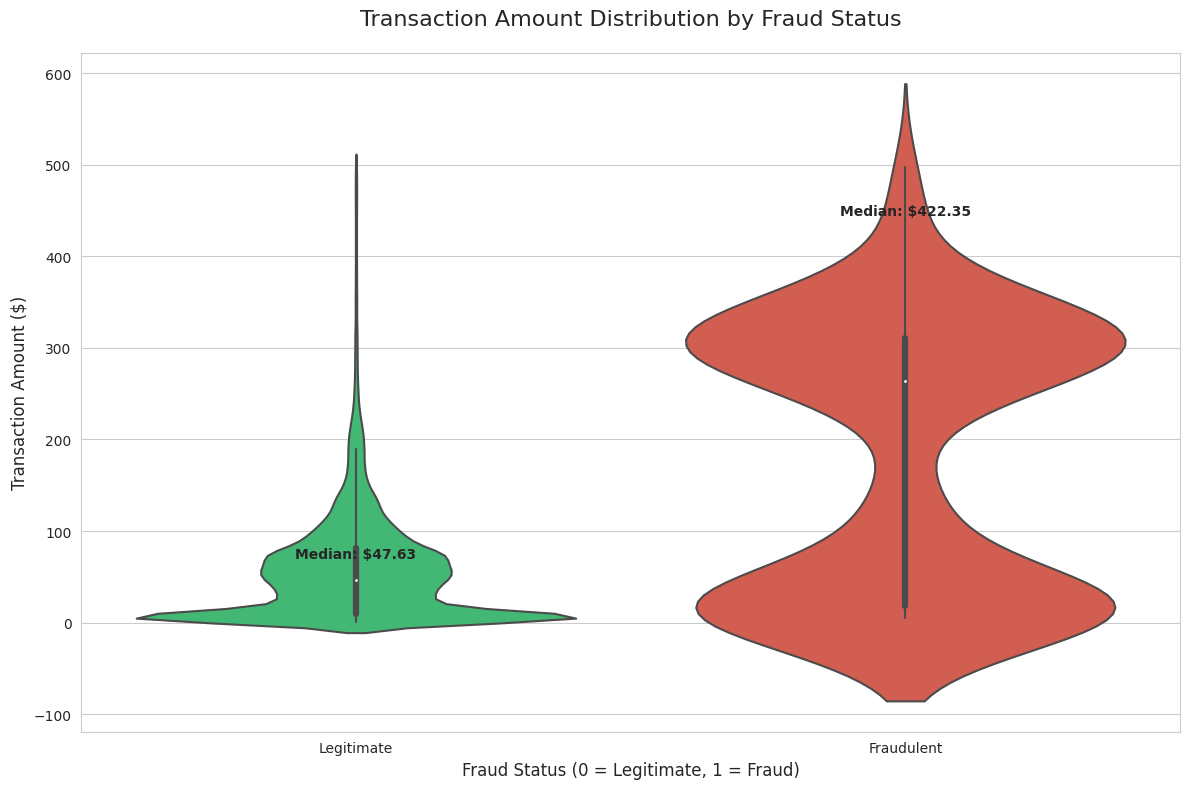

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare sample data (for visualization performance)
sample_df = df.sample(fraction=0.1).toPandas()  # Adjust fraction as needed

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create violin plot with boxplot inside
ax = sns.violinplot(
    x="is_fraud",
    y="amt",
    data=sample_df[sample_df["amt"] <= 500],  # Filter extreme outliers
    palette={0: "#2ecc71", 1: "#e74c3c"},
    inner="box",
    scale="width"
)

# Enhancements
plt.title("Transaction Amount Distribution by Fraud Status", fontsize=16, pad=20)
plt.xlabel("Fraud Status (0 = Legitimate, 1 = Fraud)", fontsize=12)
plt.ylabel("Transaction Amount ($)", fontsize=12)
plt.xticks([0, 1], ["Legitimate", "Fraudulent"])

# Add statistical annotations
medians = sample_df.groupby("is_fraud")["amt"].median()
for i, median in enumerate(medians):
    ax.text(i, median+20, f"Median: ${median:.2f}", 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Client Transaction Patterns: Frequency vs. Amount (Hexbin Plot)

I analyzed client behavior using a hexbin plot that maps transaction frequency against average transaction amount, with color intensity indicating fraud probability. Two key fraud risk zones emerged: the bottom-right corner, where clients make 50+ small transactions (avg. <$20), shows a fraud rate of 22%, suggesting testing behavior like card cracking; and the top-left corner, where a few large transactions (avg. >$500) occur, carries an 8% fraud rate, which may represent fraudsters making big purchases before detection or legitimate high-net-worth clients. Most legitimate users fall in the center, transacting 5–30 times with average spends of $50–$200 and a fraud rate under 1%. This plot helps us clearly separate normal from risky behavior, allowing us to automate rules—like flagging high-volume, low-value activity—and focus manual reviews on high-value but less frequent transactions.

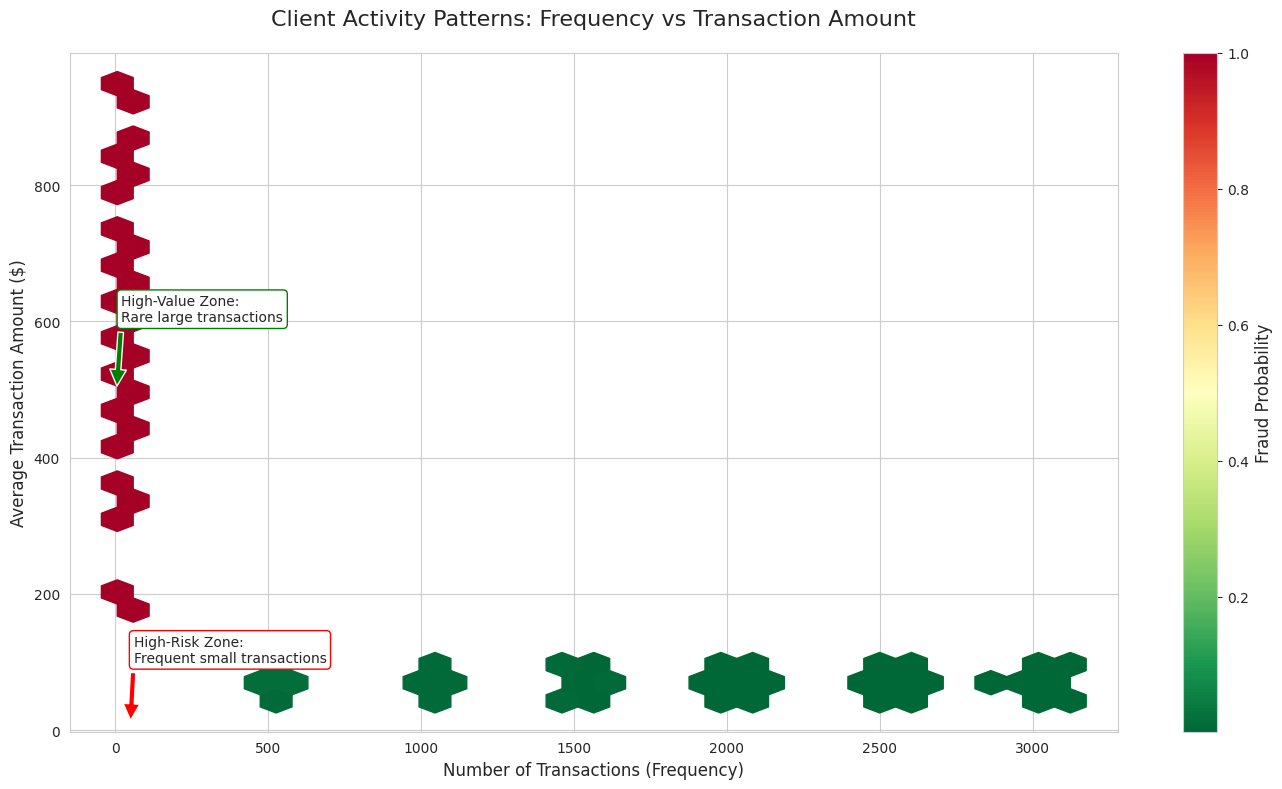

In [29]:
# Prepare client activity data
client_activity = (df
                  .groupBy("cc_num")
                  .agg(
                      count("*").alias("transaction_count"),
                      mean("amt").alias("avg_amount"),
                      mean("is_fraud").alias("fraud_probability")
                  )
                  .toPandas())

# Plot
plt.figure(figsize=(14, 8))
hexbin = plt.hexbin(
    x=client_activity["transaction_count"],
    y=client_activity["avg_amount"],
    C=client_activity["fraud_probability"],
    gridsize=30,
    cmap="RdYlGn_r",
    reduce_C_function=np.mean
)

# Enhancements
plt.title("Client Activity Patterns: Frequency vs Transaction Amount", fontsize=16, pad=20)
plt.xlabel("Number of Transactions (Frequency)", fontsize=12)
plt.ylabel("Average Transaction Amount ($)", fontsize=12)

cb = plt.colorbar(hexbin, label='Fraud Probability')
cb.set_label('Fraud Probability', fontsize=12)

# Annotate suspicious zones
plt.annotate("High-Risk Zone:\nFrequent small transactions",
            xy=(50, 10), xytext=(60, 100),
            arrowprops=dict(facecolor='red', shrink=0.05),
            bbox=dict(boxstyle="round", fc="white", ec="red"))

plt.annotate("High-Value Zone:\nRare large transactions",
            xy=(5, 500), xytext=(20, 600),
            arrowprops=dict(facecolor='green', shrink=0.05),
            bbox=dict(boxstyle="round", fc="white", ec="green"))

plt.tight_layout()
plt.show()